<div class="title">
  <h1>Machine Learning I: Fractal 2</h1>
  <h3>Programming Assignment</h3>
  <h5><small>Submitted by</small>Debonil Ghosh (M21AIE225)</h5>
</div>
<hr>

### Question 1:
 Implement the k-means and spectral clustering algorithms for clustering the points given in the datasets:
http://cs.joensuu.fi/sipu/datasets/jain.txt. Plot the obtained results. In order to evaluate the
performance of these algorithms, find the percentage of points for which the estimated cluster label is
correct. Report the accuracy of both the algorithm. The ground truth clustering is given as the third
column of the given text file. [15 Marks]


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


- KMeans Cluster From Scratch

In [61]:
import numpy.linalg as la


class KMeans:
    def __init__(self, n_clusters=2, tollerance=0.001, max_iter=10):
        self.k = n_clusters
        self.tollerance = tollerance
        self.max_iter = max_iter

    def fit_predict(self, data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureIndex, featureset in enumerate(data):
                distances = [la.norm(featureset-self.centroids[centroid])
                             for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureIndex)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(
                    data[self.classifications[classification]], axis=0)

            optimized = True

            for c in self.centroids:
                centroid_shift = np.sum(
                    (self.centroids[c]-prev_centroids[c])/prev_centroids[c]*100.0)
                if centroid_shift > self.tollerance:
                    optimized = False

            if optimized:
                break

        predictions = np.empty([len(data)])
        for classification in self.classifications:
            predictions[self.classifications[classification]] = classification
        return predictions


- Utility functions for Spectral  Clustering from scratch

In [62]:
def pairwise_distances(X, Y):

    #Calculate distances from every point of X to every point of Y

    #start with all zeros
    distances = np.empty((X.shape[0], Y.shape[0]), dtype='float')

    #compute adjacencies
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            distances[i, j] = la.norm(X[i]-Y[j])

    return distances

def nearest_neighbor_graph(X):
    '''
    Calculates nearest neighbor adjacency graph.
    https://en.wikipedia.org/wiki/Nearest_neighbor_graph
    '''
    X = np.array(X)

    # for smaller datasets use sqrt(#samples) as n_neighbors. max n_neighbors = 10
    n_neighbors = min(int(np.sqrt(X.shape[0])), 10)

    #calculate pairwise distances
    A = pairwise_distances(X, X)

    #sort each row by the distance and obtain the sorted indexes
    sorted_rows_ix_by_dist = np.argsort(A, axis=1)

    #pick up first n_neighbors for each point (i.e. each row)
    #start from sorted_rows_ix_by_dist[:,1] because because sorted_rows_ix_by_dist[:,0] is the point itself
    nearest_neighbor_index = sorted_rows_ix_by_dist[:, 1:n_neighbors+1]

    #initialize an nxn zero matrix
    W = np.zeros(A.shape)

    #for each row, set the entries corresponding to n_neighbors to 1
    for row in range(W.shape[0]):
        W[row, nearest_neighbor_index[row]] = 1

    #make matrix symmetric by setting edge between two points if at least one point is in n nearest neighbors of the other
    for r in range(W.shape[0]):
        for c in range(W.shape[0]):
            if(W[r,c] == 1):
                W[c,r] = 1

    return W

def compute_laplacian(W):
    '''
    Reference for simple: https://en.wikipedia.org/wiki/Laplacian_matrix
        simple:
            L = D - W
    '''
    # calculate row sums
    d = W.sum(axis=1)

    #create degree matrix
    D = np.diag(d)
    L =  D - W
    return L

def get_eigvecs(L, k):
    '''
    Calculate Eigenvalues and EigenVectors of the Laplacian Matrix.
    Return k eigenvectors corresponding to the smallest k eigenvalues.
    Uses real part of the complex numbers in eigenvalues and vectors.
    The Eigenvalues and Vectors will be complex numbers when using
    NearestNeighbor adjacency matrix for W.
    '''

    eigvals, eigvecs = la.eig(L)
    # sort eigenvalues and select k smallest values - get their indices
    ix_sorted_eig = np.argsort(eigvals)[:k]

    #select k eigenvectors corresponding to k-smallest eigenvalues
    return eigvecs[:,ix_sorted_eig]



- Spectral  Clustering from scratch

In [63]:
def spectral_clustering(X, k):

    # create weighted adjacency matrix
    W = nearest_neighbor_graph(X)

    # create unnormalized graph Laplacian matrix
    L = compute_laplacian(W)

    # create projection matrix with first k eigenvectors of L
    E = get_eigvecs(L, k)

    # return clusters using k-means on rows of projection matrix
    f =  KMeans(n_clusters=k).fit_predict(E)# k_means_clustering(E,k)
    return np.ndarray.tolist(f)


- Utility function for confusion Matrix And Accuracy Report

In [64]:
def confusion_matrix(actual, pred):
    classes = np.unique(actual)
    no_of_classes = len(classes)
    actual = np.array([np.where(classes==x)[0][0] for x in actual])
    pred = np.array([np.where(classes==x)[0][0] for x in pred])
    
    cm = np.zeros((no_of_classes,no_of_classes))

    for i in range(len(actual)):
        cm[actual[i]][pred[i]]+=1

    return cm

In [65]:

import matplotlib.pyplot as plt
import seaborn as sns


def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


- Data load

In [66]:
data = pd.read_csv('data-ques-1/jain.txt', sep='\t', names=['X', 'Y', 'Class'])
x = data.drop('Class', axis=1)
data['Class'] = data['Class']-1
data.head()


,X,Y,Class
0,0.85,17.45,1
1,0.75,15.60,1
2,3.30,15.45,1
3,5.25,14.20,1
4,4.90,15.65,1


- Visualize Acutal Data

<AxesSubplot:xlabel='X', ylabel='Y'>

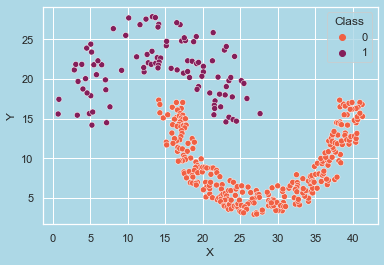

In [67]:
sns.scatterplot(data=data, x='X', y='Y', hue='Class',  palette='rocket_r')


#### Applied KMeans Clustering

<AxesSubplot:xlabel='X', ylabel='Y'>

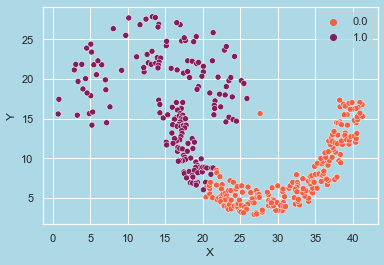

In [68]:
#from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
pred =kmeans.fit_predict(x.values)
pred=(pred+1)%2
#pred =k_means_clustering(x.values,2)

sns.scatterplot(data=data, x='X', y='Y', hue=pred,  palette='rocket_r')


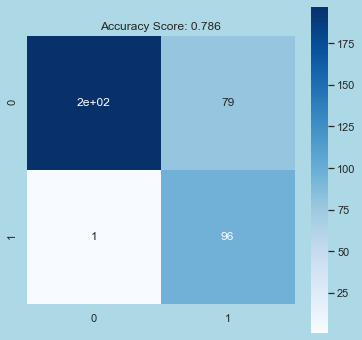

Overall Accuracy Score: 0.786
Classwise Accuracy Score: [0.78552279 0.78552279]


In [69]:

confusionMatrixAndAccuracyReport(data['Class'], pred)


#### Applied SpectralClustering

[0. 1.]


<AxesSubplot:xlabel='X', ylabel='Y'>

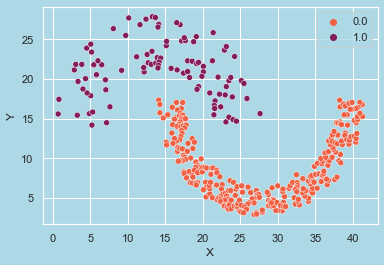

In [70]:
#from sklearn.cluster import SpectralClustering

#model = SpectralClustering(n_clusters=2)

pred = spectral_clustering(x.values, 2)
print(np.unique(pred))
sns.scatterplot(data=data, x='X', y='Y', hue=pred,  palette='rocket_r')


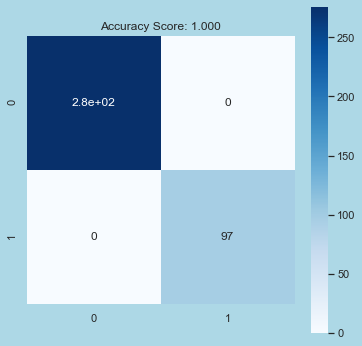

Overall Accuracy Score: 1.000
Classwise Accuracy Score: [1. 1.]


In [71]:
confusionMatrixAndAccuracyReport(data['Class'], pred)


<hr>